## 1. Import libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

## 2. Import data

In [2]:
# Configure API key 
quandl.ApiConfig.api_key = 'wAUPTrc_ZuQA4mnqeomK'

In [3]:
# Importing Federal Reserve Economic Data "New Private Housing Units Authorized by Building Permits for the South Atlantic Census Divison" variable
data = quandl.get('FRED/CSATBPPRIVSA')

## 3. Data wrangling & cleaning

In [4]:
# Display dataframe first 5 rows
data.head(5)

,Value
Date,
1988-01-01,27050.829216
1988-02-01,38135.856483
1988-03-01,37818.992385
1988-04-01,35191.287499
1988-05-01,34028.666303


In [5]:
data.tail(5)

,Value
Date,
2020-10-01,35827.804545
2020-11-01,37319.400929
2020-12-01,39147.242622
2021-01-01,37449.159854
2021-02-01,38080.218189


In [6]:
# Check # of rows and columns
data.shape

(398, 1)

In [7]:
# Check column info
data.columns

Index(['Value'], dtype='object')

In [8]:
# Check data type
type(data)

pandas.core.frame.DataFrame

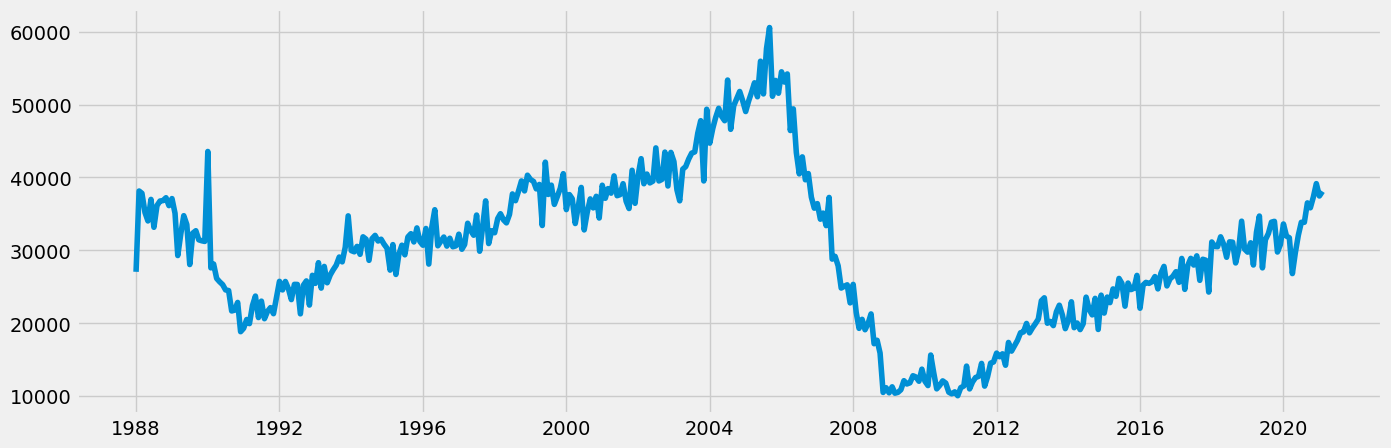

In [9]:
# Plot the data using matplotlib
plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

I chose not to create a subset with this data. As the data is from 1988 to 2020, there are no irrelevant historical events and no forecasted data in this time frame that would result in bias in the analysis.

In [10]:
# Check for missing values 
data.isnull().sum() 

Value    0
dtype: int64

In [11]:
# Check for duplicates
dups = data.duplicated()
dups.sum()

0

## 4. Time-series analysis: decomposition

In [12]:
# Decompose time series using multiplicative model
decomposition = sm.tsa.seasonal_decompose(data, model='multiplicative')

In [13]:
# Define a fixed size for all special charts
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

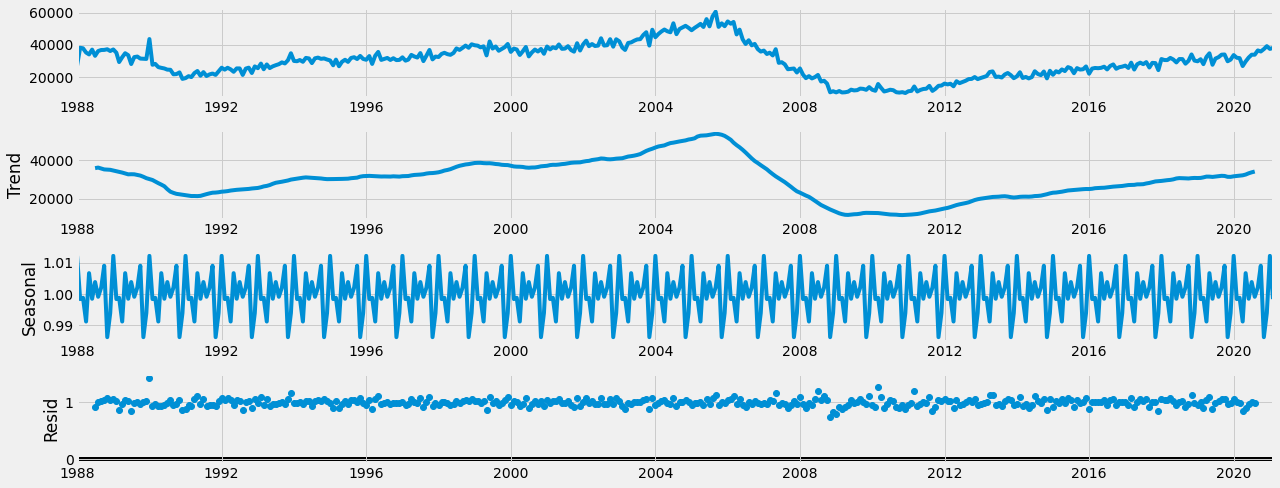

In [14]:
# Plot separate components
decomposition.plot()
plt.show()

As the level and trend are different, this informs us that the data is unsmoothed. The trend component displays some fluctuations with a steady increase over the years starting around 1991 with a decline around 2006 which is likely represented by the housing financial crisis which last for several years before steadly increasing again around 2011. The seasonality component displays fluctuations indicating season fluctuations at a regular interval. The residual shows that there isn't too much unexplained noise with a few deviations around 1990 and 2009 which represent downward trends on the line chart. Overall, there does not appear to be a dominant trend, seasonality is present, and there does not appear to be much residual noise left over. As seasonality is present, but not a trend, it can not be officially implied that the series is non-stationary with need for more testing.

## 5. Test for stationarity

In [15]:
# Import adfuller() function, perform Dickey-Fuller Test, and apply test using function on time series

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.190637
p-value                          0.209661
Number of Lags Used             15.000000
Number of Observations Used    382.000000
Critical Value (1%)             -3.447585
Critical Value (5%)             -2.869136
Critical Value (10%)            -2.570816
dtype: float64


The test statistic is -2.1 and the p-value is 0.2 which indicates the test result is not significant as it is more than 0.05. Using the critical value (5%) which is -2.8, it is much smaller than the test statistic. This means you cannot reject the null hypothesis. This indicates that there is a unit root in the data and that the data is likely non-stationary.

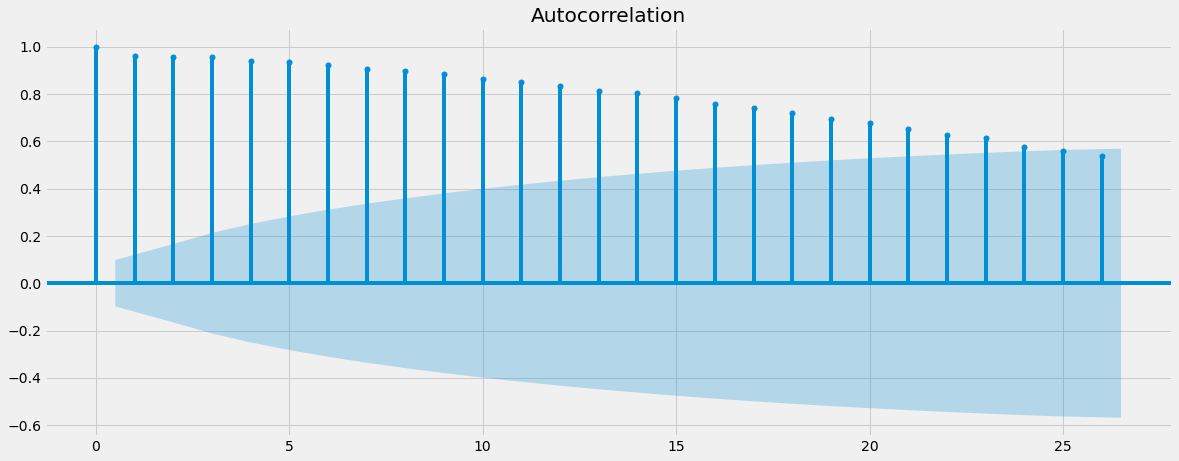

In [16]:
# Plot autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data)
plt.show()

The autocorrelation shows that there are many lags beyond the confidence interval likely indicating the data is non-stationary and there is autocorrelated data. The Dickey-Fuller test was correct in stating the data is non-stationary. 

## 6. Stationarize data

In [17]:
# Calculate difference between every values and its lag, then store results in new dataframe
data_diff = data - data.shift(1) 

In [18]:
# Remove any missing values
data_diff.dropna(inplace = True) 

In [19]:
# Display dataframe
data_diff.head()

,Value
Date,
1988-02-01,11085.027267
1988-03-01,-316.864098
1988-04-01,-2627.704886
1988-05-01,-1162.621196
1988-06-01,2955.767152


In [20]:
# Display column information
data_diff.columns

Index(['Value'], dtype='object')

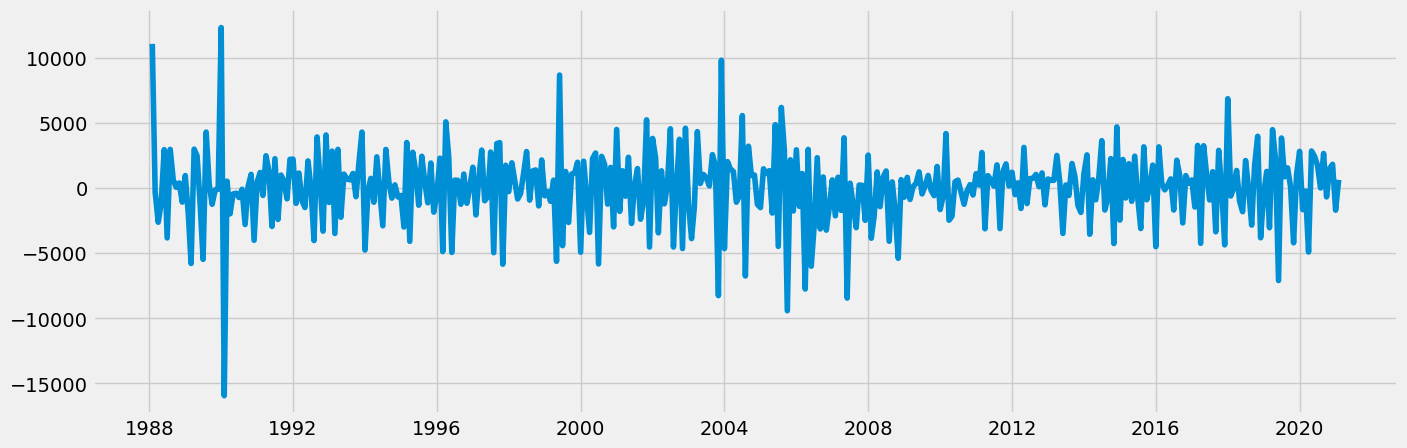

In [21]:
# Display time series with differencing
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [22]:
# Perform Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.054707
p-value                          0.001150
Number of Lags Used             12.000000
Number of Observations Used    384.000000
Critical Value (1%)             -3.447495
Critical Value (5%)             -2.869096
Critical Value (10%)            -2.570795
dtype: float64


With differencing, the test-statistic (-4.0) is now smaller than the critical values at 5% (-2.8) and at 10% (-2.5). The null hypothesis can be rejected and the series is now stationary. The test result is also significant as the p-value is less than 0.05.

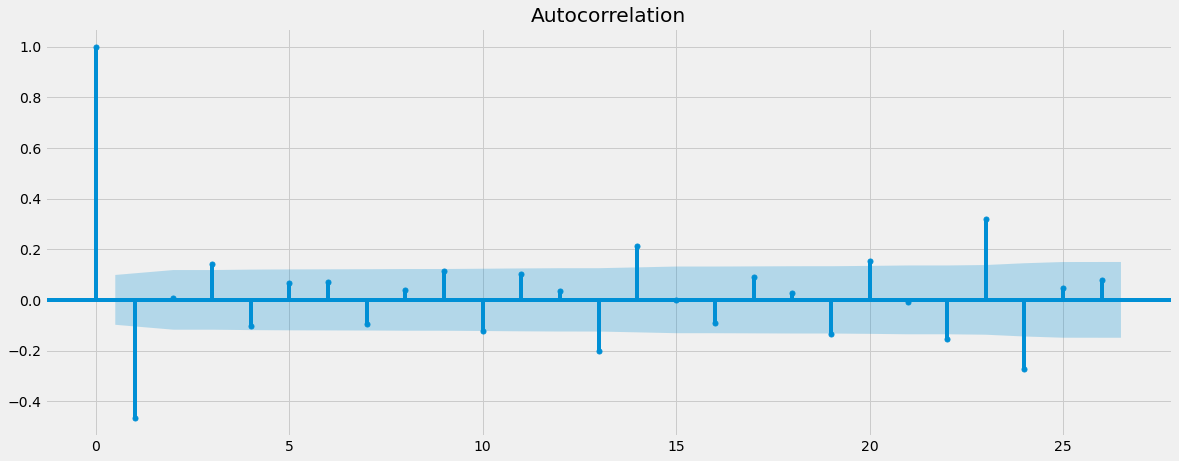

In [23]:
# Display autocorrelation
plot_acf(data_diff)
plt.show()

The autocorrelation is significantly different with few autocorrelated terms. However, as there are still lags outside of the confidence interval, it indicates a weak stationarity. As there are less than 10 significant lags, a second round of differencing is not necessary.